<a href="https://colab.research.google.com/github/lqh52/Coursera_Capstone/blob/main/Capstone_Project_The_Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods


### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Business Problem](#bp)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

## Business Problem <a name="bp"></a>

This project aims to find the most suitable and secure location for opening some kinds of business places like **Grocery Store**, **Gas Station**,... in in **Toronto**, Canada.
We will usedata science tools to analyse data and focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood where grocery store is not amongst the most common venues can be selected.


## Data <a name="data"></a>

Based on definition of our problem, we must:
* Find the safest borough based on crime statistics
* Find the most common venues

Following data will be needed to extract the required information:

[**Part 1**: Using a real world data set from Kaggle containing the Toronto Police Data from 2014 to 2019](#part1):  A dataset consisting of the crime statistics of Toronto along with coordinates of neighborhoods, type of crime, and record time.

[**Part 2**: Use the data from Wikipedia about neighborhoods and borough in Toronto.](#part2): Borough information will be used to map the existing data where each neighbourhood can be assigned with the right borough.

[**Part 3**: Find the safest borough](#part3): Analyse the data and find the safest places.



###**Part 1:** Using a real world data set from Kaggle containing the Toronto from 2014 to 2019<a name="part1"></a>

Data set URL: https://www.kaggle.com/kapastor/toronto-police-data-crime-rates-by-neighbourhood

### Importing all the necessary Libraries

In [ ]:
import numpy as np
import pandas as pd

#install OpenCage Geocoder for fetching Lat and Lng of Neighborhood
!pip install opencage

!pip install geocoder

import geocoder

#Importing OpenCage Geocoder
from opencage.geocoder import OpenCageGeocode

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#Importing folium to visualise Maps and plot based on Lat and Lng
import folium

#Requests to request web pages by making get requests to FourSquare REST Client
import requests

#To normalise data returned by FourSquare API
from pandas.io.json import json_normalize

#Importing KMeans from SciKit library to Classify neighborhoods into clusters
from sklearn.cluster import KMeans

     |████████████████████████████████| 102kB 5.3MB/s 


###Reading the Dataset

In [ ]:
toronto_crime = pd.read_csv('/content/MCI_2014_to_2019.csv')
toronto_crime

,X,Y,Index_,event_unique_id,occurrencedate,reporteddate,premisetype,ucr_code,ucr_ext,offence,reportedyear,reportedmonth,reportedday,reporteddayofyear,reporteddayofweek,reportedhour,occurrenceyear,occurrencemonth,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,MCI,Division,Hood_ID,Neighbourhood,Long,Lat,ObjectId
0,-79.405228,43.656982,7801,GO-20152165447,2015-12-18T03:58:00.000Z,2015-12-18T03:59:00.000Z,Commercial,1430,100,Assault,2015,December,18,352,Friday,3,2015.0,December,18.0,352.0,Friday,3,Assault,D14,79.0,University (79),-79.405228,43.656982,7001.0
1,-79.307907,43.778732,7802,GO-20151417245,2015-08-15T21:45:00.000Z,2015-08-17T22:11:00.000Z,Commercial,1430,100,Assault,2015,August,17,229,Monday,22,2015.0,August,15.0,227.0,Saturday,21,Assault,D42,118.0,Tam O'Shanter-Sullivan (118),-79.307907,43.778732,7002.0
2,-79.225029,43.765942,7803,GO-20151421107,2015-08-16T16:00:00.000Z,2015-08-18T14:40:00.000Z,Apartment,2120,200,B&E,2015,August,18,230,Tuesday,14,2015.0,August,16.0,228.0,Sunday,16,Break and Enter,D43,137.0,Woburn (137),-79.225029,43.765942,7003.0
3,-79.140823,43.778648,7804,GO-20152167714,2015-11-26T13:00:00.000Z,2015-12-18T13:38:00.000Z,Other,2120,200,B&E,2015,December,18,352,Friday,13,2015.0,November,26.0,330.0,Thursday,13,Break and Enter,D43,133.0,Centennial Scarborough (133),-79.140823,43.778648,7004.0
4,-79.288361,43.691235,7805,GO-20152169954,2015-12-18T19:50:00.000Z,2015-12-18T19:55:00.000Z,Commercial,1430,100,Assault,2015,December,18,352,Friday,19,2015.0,December,18.0,352.0,Friday,19,Assault,D55,61.0,Taylor-Massey (61),-79.288361,43.691235,7005.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8154,-79.331421,43.662998,15940,GO-20151776717,2015-10-15T12:45:00.000Z,2015-10-15T14:17:00.000Z,House,1430,100,Assault,2015,October,15,288,Thursday,14,2015.0,October,15.0,288.0,Thursday,12,Assault,D55,70.0,South Riverdale (70),-79.331421,43.662998,15155.0
8155,-79.542381,43.752094,15941,GO-20151780161,2015-10-15T23:15:00.000Z,2015-10-15T23:29:00.000Z,Apartment,1430,100,Assault,2015,October,15,288,Thursday,23,2015.0,October,15.0,288.0,Thursday,23,Assault,D31,22.0,Humbermede (22),-79.542381,43.752094,15156.0
8156,-79.542381,43.752094,15942,GO-20151780161,2015-10-15T23:15:00.000Z,2015-10-15T23:29:00.000Z,Apartment,1430,100,Assault,2015,October,15,288,Thursday,23,2015.0,October,15.0,288.0,Thursday,23,Assault,D31,22.0,Humbermede (22),-79.542381,43.752094,15157.0
8157,-79.373062,43.663193,15943,GO-20151813077,2015-10-21T15:59:00.000Z,2015-10-21T15:59:00.000Z,Outside,1430,100,Assault,2015,October,21,294,Wednesday,15,2015.0,October,21.0,294.0,Wednesday,15,Assault,D51,71.0,Cabbagetown-South St.James Town (71),-79.373062,43.663193,15158.0


In [ ]:
#We just collect the important data
toronto_crime_df = toronto_crime[['Lat', 'Long', 'offence', 'reportedyear', 'Neighbourhood']]
toronto_crime_df

,Lat,Long,offence,reportedyear,Neighbourhood
0,43.656982,-79.405228,Assault,2015,University (79)
1,43.778732,-79.307907,Assault,2015,Tam O'Shanter-Sullivan (118)
2,43.765942,-79.225029,B&E,2015,Woburn (137)
3,43.778648,-79.140823,B&E,2015,Centennial Scarborough (133)
4,43.691235,-79.288361,Assault,2015,Taylor-Massey (61)
...,...,...,...,...,...
8154,43.662998,-79.331421,Assault,2015,South Riverdale (70)
8155,43.752094,-79.542381,Assault,2015,Humbermede (22)
8156,43.752094,-79.542381,Assault,2015,Humbermede (22)
8157,43.663193,-79.373062,Assault,2015,Cabbagetown-South St.James Town (71)


In [ ]:
#clean the data
toronto_crime_df['Neighbourhood'] = toronto_crime_df['Neighbourhood'].str.replace('\(.*\)','')
toronto_crime_df['Neighbourhood'] = toronto_crime_df['Neighbourhood'].str.strip()
toronto_crime_df = toronto_crime_df.dropna()
toronto_crime_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Lat,Long,offence,reportedyear,Neighbourhood
0,43.656982,-79.405228,Assault,2015,University
1,43.778732,-79.307907,Assault,2015,Tam O'Shanter-Sullivan
2,43.765942,-79.225029,B&E,2015,Woburn
3,43.778648,-79.140823,B&E,2015,Centennial Scarborough
4,43.691235,-79.288361,Assault,2015,Taylor-Massey
...,...,...,...,...,...
8153,43.651897,-79.381714,Assault Bodily Harm,2015,Bay Street Corridor
8154,43.662998,-79.331421,Assault,2015,South Riverdale
8155,43.752094,-79.542381,Assault,2015,Humbermede
8156,43.752094,-79.542381,Assault,2015,Humbermede


###Total Crimes in different Neighborhoods

In [ ]:
toronto_crime_df['Neighbourhood'].value_counts()

Waterfront Communities-The Island    317
Bay Street Corridor                  265
Church-Yonge Corridor                246
West Humber-Clairville               183
Moss Park                            178
                                    ... 
Runnymede-Bloor West Village          15
Bayview Woods-Steeles                 15
Forest Hill South                     14
Humber Heights-Westmount              14
Maple Leaf                            13
Name: Neighbourhood, Length: 140, dtype: int64

In [ ]:
toronto_crime_df['Neighbourhood'].unique()

array(['University', "Tam O'Shanter-Sullivan", 'Woburn',
       'Centennial Scarborough', 'Taylor-Massey', 'Broadview North',
       'Bay Street Corridor', 'West Humber-Clairville',
       'Forest Hill North', 'Downsview-Roding-CFB',
       'Bedford Park-Nortown', 'Malvern',
       'Waterfront Communities-The Island', 'Eglinton East',
       'Thistletown-Beaumond Heights', 'Annex', 'Agincourt North',
       'Bayview Village', 'Mount Pleasant West', 'Humber Summit',
       'Oakwood Village', 'Oakridge', 'Moss Park', 'North St.James Town',
       'Mimico', 'Islington-City Centre West', 'Niagara',
       'York University Heights', 'Dorset Park', 'Kennedy Park',
       'South Riverdale', 'Dovercourt-Wallace Emerson-Junction',
       'Stonegate-Queensway', 'Humbermede', 'New Toronto', 'Rouge',
       'Ionview', 'Rockcliffe-Smythe', 'Clairlea-Birchmount',
       'Junction Area', 'Morningside', 'Glenfield-Jane Heights', 'Rustic',
       'Regent Park', 'The Beaches', 'Danforth', 'High Park-Swa

### **Part 2**: Use the data from Wikipedia about neighborhoods and borough in Toronto. <a name="part2"></a>

URL: https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto

Read data from dataset collected from Wikipedia

In [ ]:
data_scraper = pd.read_html('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Toronto')
print(f'Total tables: {len(data_scraper)}')

Total tables: 16


In [ ]:
data_scraper[10]

,CDN number,City-designated neighbourhood,Former city/borough,Neighbourhoods covered,Map,Unnamed: 5
0,129,Agincourt North,Scarborough,Agincourt and Brimwood,NaN,NaN
1,128,Agincourt South-Malvern West,Scarborough,Agincourt and Malvern,NaN,NaN
2,20,Alderwood,Etobicoke,Alderwood,NaN,NaN
3,95,Annex,Old City of Toronto,The Annex and Seaton Village,NaN,NaN
4,42,Banbury-Don Mills,North York,Don Mills,NaN,NaN
...,...,...,...,...,...,...
135,94,Wychwood,Old City of Toronto,NaN,NaN,NaN
136,100,Yonge and Eglinton,Old City of Toronto,Chaplin Estates,NaN,NaN
137,97,Yonge-St.Clair,Old City of Toronto,NaN,NaN,NaN
138,27,York University Heights,North York,NaN,NaN,NaN


In [ ]:
toronto_boroughs = data_scraper[10].drop(['CDN number', 'Neighbourhoods covered', 'Map', 'Unnamed: 5'], axis = 1)

In [ ]:
toronto_boroughs.rename(columns={'City-designated neighbourhood': 'Neighbourhood', 'Former city/borough':'Borough'}, inplace = True)
toronto_boroughs.head()

,Neighbourhood,Borough
0,Agincourt North,Scarborough
1,Agincourt South-Malvern West,Scarborough
2,Alderwood,Etobicoke
3,Annex,Old City of Toronto
4,Banbury-Don Mills,North York


###Merge the borough data and crime data

In [ ]:
toronto_borough_crime = pd.merge(toronto_crime_df,toronto_boroughs, on='Neighbourhood')

toronto_borough_crime

,Lat,Long,offence,reportedyear,Neighbourhood,Borough
0,43.656982,-79.405228,Assault,2015,University,Old City of Toronto
1,43.661518,-79.409767,B&E,2015,University,Old City of Toronto
2,43.666660,-79.403870,Assault,2015,University,Old City of Toronto
3,43.665916,-79.407471,Assault Bodily Harm,2015,University,Old City of Toronto
4,43.657951,-79.400047,Assault,2015,University,Old City of Toronto
...,...,...,...,...,...,...
7715,43.709774,-79.481880,Assault Bodily Harm,2015,Maple Leaf,North York
7716,43.706375,-79.487671,Theft Over,2015,Maple Leaf,North York
7717,43.707474,-79.488113,B&E W'Intent,2014,Maple Leaf,North York
7718,43.708660,-79.478065,Assault,2014,Maple Leaf,North York


In [ ]:
toronto_borough_crime.rename(columns={'offence': 'Type', 'reportedyear':'Year'}, inplace=True)
toronto_borough_crime

,Lat,Long,Type,Year,Neighbourhood,Borough
0,43.656982,-79.405228,Assault,2015,University,Old City of Toronto
1,43.661518,-79.409767,B&E,2015,University,Old City of Toronto
2,43.666660,-79.403870,Assault,2015,University,Old City of Toronto
3,43.665916,-79.407471,Assault Bodily Harm,2015,University,Old City of Toronto
4,43.657951,-79.400047,Assault,2015,University,Old City of Toronto
...,...,...,...,...,...,...
7715,43.709774,-79.481880,Assault Bodily Harm,2015,Maple Leaf,North York
7716,43.706375,-79.487671,Theft Over,2015,Maple Leaf,North York
7717,43.707474,-79.488113,B&E W'Intent,2014,Maple Leaf,North York
7718,43.708660,-79.478065,Assault,2014,Maple Leaf,North York


In [ ]:
toronto_borough_crime['Borough'].value_counts()

Old City of Toronto    2842
Scarborough            1745
North York             1636
Etobicoke               920
York                    376
East York               201
Name: Borough, dtype: int64

##Methodology<a name="methodology"></a>

Categorized the methodologysection into two parts:

- [**Exploratory Data Analysis**:](#eda) Visualise the crime reports in different boroughs to idenity the safest borough and normalise the neighborhoods of that borough.

- [**Modelling**:](#mdl) To help stakeholders choose the right neighborhood within a borough we will be clustering similar neighborhoods using K - means clustering to address this problem so as to group data based on existing venues which will help in the decision making process.

#### Visualize the data

In [ ]:
toronto_crime_neigh = pd.pivot_table(toronto_borough_crime,
                               values=['Year'],
                               index=['Neighbourhood'],
                               columns=['Type'],
                               aggfunc=len,
                               fill_value=0,
                               margins=True)
toronto_crime_neigh

Year  ...      
Type                         Administering Noxious Thing  ...   All
Neighbourhood                                             ...      
Agincourt North                                        0  ...    36
Agincourt South-Malvern West                           0  ...    81
Alderwood                                              0  ...    23
Annex                                                  1  ...   118
Banbury-Don Mills                                      0  ...    57
...                                                  ...  ...   ...
Wychwood                                               0  ...    32
Yonge-St.Clair                                         0  ...    21
York University Heights                                1  ...   145
Yorkdale-Glen Park                                     0  ...    58
All                                                    7  ...  7720

[133 rows x 39 columns]

In [ ]:
toronto_crime_neigh.describe()

Year  ...             
Type  Administering Noxious Thing  ...          All
count                  133.000000  ...   133.000000
mean                     0.105263  ...   116.090226
std                      0.642712  ...   666.225420
min                      0.000000  ...    13.000000
25%                      0.000000  ...    26.000000
50%                      0.000000  ...    40.000000
75%                      0.000000  ...    71.000000
max                      7.000000  ...  7720.000000

[8 rows x 39 columns]

##### 5 Neighborhoods with highest crime

In [ ]:
total_crime_neighbor = toronto_crime_df['Neighbourhood'].value_counts()

In [ ]:
total_crime_neighbor = total_crime_neighbor.rename_axis('Neighbourhood').reset_index(name='Total')
total_crime_neighbor

,Neighbourhood,Total
0,Waterfront Communities-The Island,317
1,Bay Street Corridor,265
2,Church-Yonge Corridor,246
3,West Humber-Clairville,183
4,Moss Park,178
...,...,...
135,Runnymede-Bloor West Village,15
136,Bayview Woods-Steeles,15
137,Forest Hill South,14
138,Humber Heights-Westmount,14


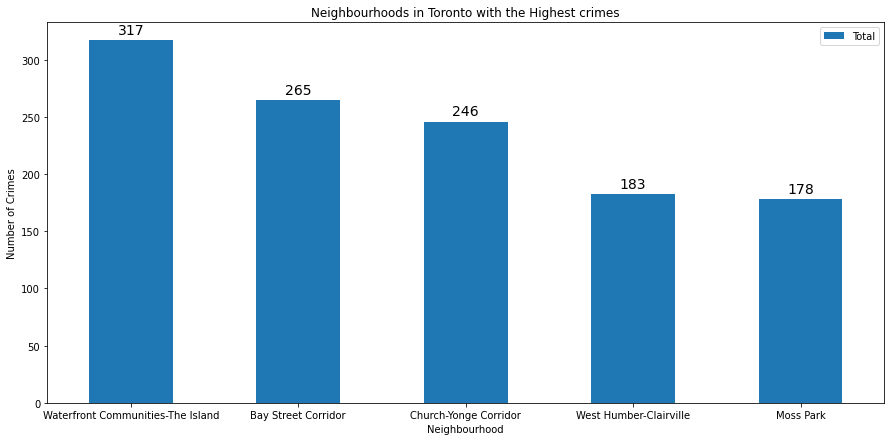

In [ ]:
per_neigh = total_crime_neighbor.iloc[0:5]

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(15, 7), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Toronto with the Highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

##### 5 Neighborhoods with lowest crime

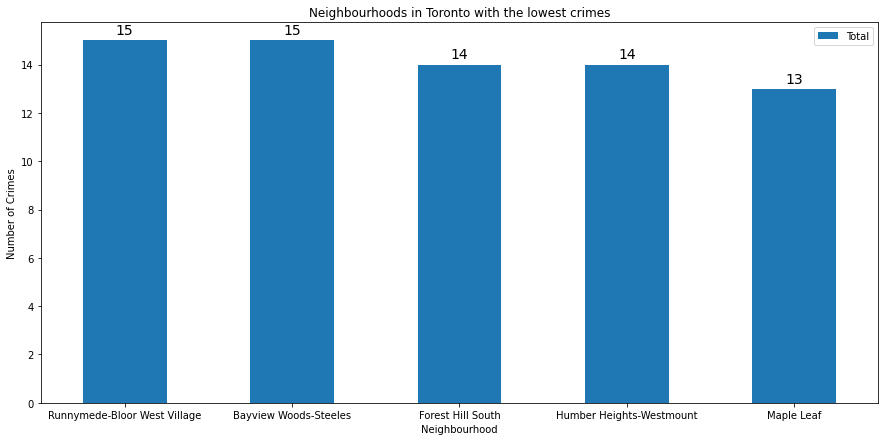

In [ ]:
per_neigh = total_crime_neighbor.tail(5)

per_neigh.set_index('Neighbourhood',inplace = True)

ax = per_neigh.plot(kind='bar', figsize=(15, 7), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Neighbourhood')
ax.set_title('Neighbourhoods in Toronto with the lowest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

#### Borough with highest crime

In [ ]:
total_crime_borough = toronto_borough_crime['Borough'].value_counts().rename_axis('Borough').reset_index(name='Total')

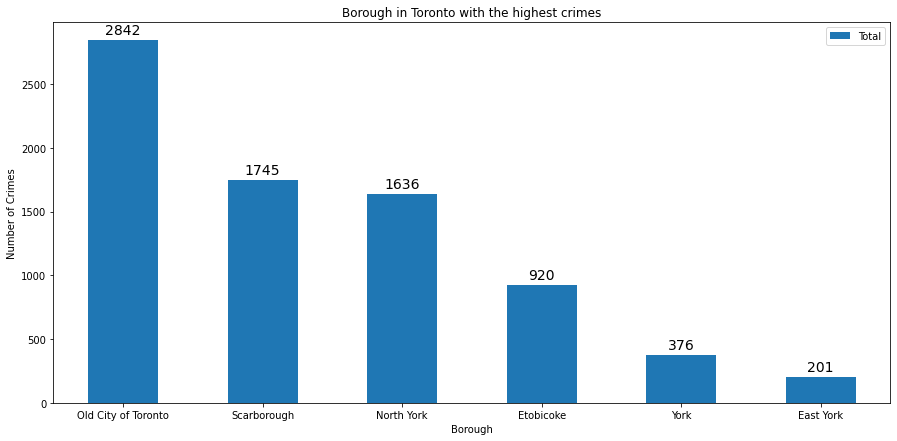

In [ ]:
per_borough = total_crime_borough

per_borough.set_index('Borough',inplace = True)

ax = per_borough.plot(kind='bar', figsize=(15, 7), rot=0)

ax.set_ylabel('Number of Crimes')
ax.set_xlabel('Borough')
ax.set_title('Borough in Toronto with the highest crimes')

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14,
               )

plt.show()

#### Based on exploratory data analysis it is clear that **East York** has the lowest crimes

### Create a map to visualize neighborhoods in East York

In [ ]:
eastyork_crime = toronto_borough_crime[toronto_borough_crime['Borough'] == 'East York']
eastyork_crime

,Lat,Long,Type,Year,Neighbourhood,Borough
322,43.688553,-79.353310,B&E,2015,Broadview North,East York
323,43.684032,-79.346786,Robbery With Weapon,2015,Broadview North,East York
324,43.688457,-79.348473,B&E,2015,Broadview North,East York
325,43.682930,-79.357216,B&E,2015,Broadview North,East York
326,43.687973,-79.350868,Assault Bodily Harm,2015,Broadview North,East York
...,...,...,...,...,...,...
7702,43.693340,-79.344810,Theft Over,2014,Old East York,East York
7703,43.695946,-79.328781,Robbery - Mugging,2014,Old East York,East York
7704,43.699722,-79.328445,B&E,2014,Old East York,East York
7705,43.690620,-79.342667,Assault,2014,Old East York,East York


####Fetching the Geographical co-ordiantes of Toronto to plot on Map

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
address = 'Toronto'

geolocator = Nominatim(user_agent="trt_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


####Using Folium to plot Toronto's East York Borough and it's Neighborhoods

In [ ]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(eastyork_crime['Lat'], eastyork_crime['Long'], eastyork_crime['Borough'], eastyork_crime['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

#### Use K-mean clustering to cluster neighborhoods in East York

In [ ]:
eastyork_grouped = eastyork_crime.groupby('Neighbourhood').mean().reset_index()

In [ ]:
# set number of clusters
kclusters = 5

eastyork_grouped_clustering = eastyork_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(eastyork_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 0, 4, 1, 0, 2], dtype=int32)

In [ ]:
# add clustering labels
eastyork_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
eastyork_grouped

,Cluster Labels,Neighbourhood,Lat,Long,Year
0,3,Broadview North,43.688003,-79.351570,2014.566667
1,0,Leaside-Bennington,43.707885,-79.369372,2014.480000
2,4,O'Connor-Parkview,43.706342,-79.304951,2014.513514
3,1,Old East York,43.695288,-79.341741,2014.333333
4,0,Thorncliffe Park,43.706012,-79.347926,2014.457143
5,2,Woodbine-Lumsden,43.693640,-79.310986,2014.625000


In [ ]:
eastyork_grouped.drop(['Lat', 'Long', 'Year'], axis=1, inplace=True)

In [ ]:
eastyork_crime = pd.merge(eastyork_crime, eastyork_grouped, on = ['Neighbourhood'])
eastyork_crime

,Lat,Long,Type,Year,Neighbourhood,Borough,Cluster Labels
0,43.688553,-79.353310,B&E,2015,Broadview North,East York,3
1,43.684032,-79.346786,Robbery With Weapon,2015,Broadview North,East York,3
2,43.688457,-79.348473,B&E,2015,Broadview North,East York,3
3,43.682930,-79.357216,B&E,2015,Broadview North,East York,3
4,43.687973,-79.350868,Assault Bodily Harm,2015,Broadview North,East York,3
...,...,...,...,...,...,...,...
196,43.693340,-79.344810,Theft Over,2014,Old East York,East York,1
197,43.695946,-79.328781,Robbery - Mugging,2014,Old East York,East York,1
198,43.699722,-79.328445,B&E,2014,Old East York,East York,1
199,43.690620,-79.342667,Assault,2014,Old East York,East York,1


In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

East York's map after clustering

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(eastyork_crime['Lat'], eastyork_crime['Long'], eastyork_crime['Neighbourhood'], eastyork_crime['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Conclusion <a name="conclusion"></a>

We have explored the crime data to understand different types of crimes in all neighborhoods of Toronto and later categorized them into different boroughs, this helped us group the neighborhoods into boroughs and choose the safest borough first. 